In [1]:
#Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

Pre-Processing

In [2]:
#Getting the data
path = '../data-unversioned'
cf10 = datasets.CIFAR10(path, train= True, download= True)
cf10_val = datasets.CIFAR10(path, train= False, download= True)

Files already downloaded and verified
Files already downloaded and verified


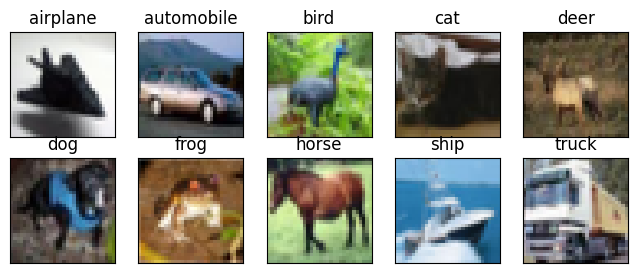

In [3]:
#Display Classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig1 = plt.figure(figsize=(8,3))
class_size = 10
for i in range(class_size):
    plt1 = fig1.add_subplot(2, 5, 1 + i, xticks= [], yticks= [])
    plt1.set_title(classes[i])
    image = next(image for image, label in cf10 if label == i)
    plt.imshow(image)
plt.show()

In [4]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


In [5]:
#Grabbing Datasets as a tensor
cf10_ten = datasets.CIFAR10(path, train= True, download= False, transform= transforms.ToTensor())
imTen, _ = cf10_ten[99]
#imTen.shape, imTen.dtype

#Image Stacking
Stacked_images = torch.stack([imTen for imTen, _ in cf10_ten], dim= 3)
Stacked_images = torch.flatten(Stacked_images)
Stacked_images.shape

torch.Size([153600000])

In [6]:
#Re-Grabbing data to normalize
transCF10 = datasets.CIFAR10(path, train= True, download= False, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
transCF10_val = datasets.CIFAR10(path, train= False, download= False, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [7]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []
val_accuracy_list = []
all_predicted = []
all_labels = []

def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for Stacked_images, labels in training_loader:
      Stacked_images = Stacked_images.to(device)
      labels = labels.to(device)
      outputs = model(Stacked_images)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    train_loss_list.append(loss_train / len(training_loader)) 

    
    #Validation Loop
    correct = 0
    total = 0
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          all_predicted.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

    val_loss_list.append(valid_loss / len(valid_loader))
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader)))


Problem 1B

In [8]:
#Model - Basic Fully Connected
modelPlus = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3072, 2058), 
    nn.ReLU(),
    nn.Linear(2058, 1024), 
    nn.ReLU(),
    nn.Linear(1024, 512), 
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10) #10 Output Classes
)

In [9]:
#Training
modelPlus = modelPlus.to(device)
a = 0.001
epochs = 20
lossFN = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelPlus.parameters(), lr= a)
training_loader = torch.utils.data.DataLoader(transCF10, batch_size= 64, shuffle= True)
valid_loader = torch.utils.data.DataLoader(transCF10_val, batch_size= 64, shuffle= True)

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= modelPlus,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader,
)

Epoch: 1, Training Loss: 2.302825330773278, Validation Loss: 2.3017968068456955
Epoch: 5, Training Loss: 2.2931507112425003, Validation Loss: 2.291336662450414
Epoch: 10, Training Loss: 2.245806020239125, Validation Loss: 2.23197551745518
Epoch: 15, Training Loss: 2.0607855358087193, Validation Loss: 2.0418023987180867
Epoch: 20, Training Loss: 1.9277450183163518, Validation Loss: 1.9107763455931548


In [10]:
# Calculate and print the accuracy
accuracy = val_accuracy_list[-1]
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print precision, recall, and F1 score
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Save the model weights
torch.save(modelPlus.state_dict(), './model/DLHW1P1B.pth')  # .pth is the recommended extension

Accuracy: 0.2958
Precision: 0.2566
Recall: 0.2027
F1 Score: 0.1622


In [11]:
#Complexity
numel_list = [p.numel() for p in modelPlus.parameters()]
print("Model Complexity: {}".format(sum(numel_list)))
#sum(numel_list), numel_list

Model Complexity: 9122964


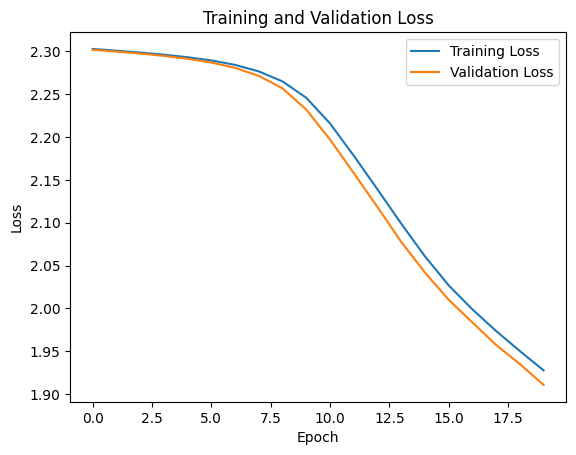

In [12]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/LeNet_training_validation_loss.png')
plt.show()